# Data Clean up
Updated on: 2022-08-18 16:54:01 CEST

Authors: Abzer Kelminal (abzer.shah@uni-tuebingen.de) <br>
Input file format: .csv files or .txt files <br>
Outputs: .csv files  <br>
Dependencies: ggplot2, dplyr, IRdisplay

This Notebook is used for cleaning the feature table, an output of metabolomics experiment, containing all the features with their corresponding intensities. The data cleanup steps involved are: 1) Blank removal 2) Imputation 3) Normalisation. Each step would be discussed in detail later.


    
This Notebook can be run with both Jupyter Notebook & Google Colab. To know more about how to get the Jupyter Notebook running with R code, please have a look at this document: [GitHub Link](https://github.com/Functional-Metabolomics-Lab/Jupyter-Notebook-Installation/blob/main/Anaconda%20with%20R%20kernel%20installation.pdf)
    
<div class="alert alert-block alert-warning">   
<b><font size=3> SPECIAL NOTE: Please read the comments before proceeding with the code and let us know if you run into any errors and if you think it could be commented better. We would highly appreciate your suggestions and comments!!</font> </b> </div>

# About the Test data:
<p style='text-align: justify;'>     
The files used in this tutorial are part of an interlab comparison study, where different laboratories around the world analysed the same environmental samples on their respective LC-MS/MS equipments. To simulate algal bloom, standardized algae extracts (A) in marine dissovled organic matter (M) at different concentrations were prepared (450 (A45M), 150 (A15M), and 50 (A5M) ppm A). Samples were then shipped to different laboratories for untargeted LC-MS/MS metabolomics analysis. In this tutorial we are working with one of the datasets, which was acquired on a UHPLC system coupled to a Thermo Scientific Q Exactive HF Orbitrap LC-MS/MS mass spectrometer. MS/MS data were acquired in data-dependent acquisition (DDA) with fragmentation of the five most abundant ions in the spectrum per precursor scan. Data files were subsequently preprocessed using MZmine3 and the feature-based molecular networking workflow in GNPS.
</p>


# Package installation:

In [20]:
#installing and calling the necessary packages:
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("dplyr")) install.packages("dplyr")
if (!require("IRdisplay")) install.packages("IRdisplay")

library(ggplot2)
library(dplyr)
library(IRdisplay)

**Global settings for plot size in the output cell:** </br>
Uncomment the line in the cell below according to the environment you use, Jupyter Notebook or Google Colab.

In [21]:
#options(repr.plot.width=10, repr.plot.height=8,res=600) #For google collab
options(repr.plot.width=5, repr.plot.height=3) #For Jupyter Notebook

# Input files needed for the Notebook:
1) <b>Feature table:</b> An output of metabolomics experiment, containing all the features or peaks (LC-MS/MS peaks here) with their corresponding intensities. The feature table used in the test data is obtained by MZmine. (Filetype: .csv file) </br> 
2) <b>Metadata:</b> Created by the user about the files used obtaining the feature table (It can be a csv/txt/tsv file). The columns in a metadata should be created with the following format: filename (1st column having all the filenames in the same order as the columns in feature table), all the other columns with column name such as: ATTRIBUTE_yourDesiredAttribute. </br>

Please have a look at the metadata used here for reference. Creating a metadata in the above-mentioned format is necessary for uploading the files in GNPS and to obtain a molecular network.

# Getting the input files:

## 1) Reading the input data using URL (from GitHub):
Here, we can directly pull the data files from our Functional Metabolomics Github page:

In [ ]:
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/MZmine/DOM_interlab_15_gnps_iimn_quant.csv'
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/MZmine/metadata_lab15.txt'

In [ ]:
ft <- read.csv(ft_url, header = T, check.names = F)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t',row.names = 1)

## 2) Setting a local working directory:

### 2.1 For direct Jupyter Notebook Users:
<p style='text-align: justify;'> <font color='green'> <b> Please make sure to include all the input files in one folder before running the script.</b> You can then simply copy the path of the folder containing all your input files in your local computer and paste it into the output line of the next cell. It will be set as your working directory (or working folder)  </font></p> 
For ex: D:\User\Project\Test_Data <br>

In [22]:
# setting the current directory as the working directory
Directory <- normalizePath(readline("Enter the path of the folder with input files: "),"/",mustWork=FALSE)
setwd(Directory)

Enter the path of the folder with input files:  D:\Projects\Metabolomics_SummerSchool_2022-main\data\dom\MZmine


In [23]:
getwd() #to get the working directory 

[1] "D:/Projects/Metabolomics_SummerSchool_2022-main/data/dom/MZmine"

### 2.2 For Google Colab Users:
<p style='text-align: justify;'> <font color='red'>For Google Colab, it is not possible to access the files from your local computer as it is hosted on Google's cloud server. An easier workaround is to upload the necessary files into the Google colab session using the 'Files' icon on the left as shown in the image. The code in the next cell creates a new folder 'My_TestData' in the Colab space and sets the folder as working directory. Following the steps in the image, you can check in your Colab to see if the folder has been created. Once you see it, simply upload the files from your local PC to the folder 'My_TestData' and then continue running the rest of the script.</font> </p>

<p style='text-align: justify;'>SPECIAL NOTE: All the files uploaded to Google Colab would generally disappear after 12 hours. Similarly, all the outputs would be saved only in the Colab, so we need to download them into our local system at the end of our session.</p> 

[Go to section: Getting outputs from Colab](#colab_output) 

In [ ]:
#Only for Google Colab:
dir.create("/content/My_TestData", showWarnings = TRUE, recursive = FALSE, mode = "0777")
setwd("/content/My_TestData")

![Google-Colab Files Upload](https://github.com/abzer005/Images-for-Jupyter-Notebooks/blob/main/StepsAll.png?raw=true)

## 3) Creating an automatic result directory:

In [24]:
# Getting all the files in the folder
dirs <- dir(path=paste(getwd(), sep=""), full.names=TRUE, recursive=TRUE)
folders <- unique(dirname(dirs))
files <- list.files(folders, full.names=TRUE)
files_1 <- basename((files))
files_2 <- dirname((files))
# Creating a Result folder
dir.create(path=paste(files_2[[1]], "_DataCleanup_Results", sep=""), showWarnings = TRUE)
fName <-paste(files_2[[1]], "_DataCleanup_Results", sep="")

IRdisplay::display(data.frame(INDEX=c(1:length(files_1)),Filename=files_1))

INDEX,Filename
1,DOM_interlab_15_gnps_iimn_edges_msannotation.csv
2,DOM_interlab_15_gnps_iimn_quant.csv
3,DOM_interlab_15_gnps_stats
4,DOM_interlab_15_sirius.mgf
5,metadata_lab15.txt


In the following line, enter the required file index numbers separated by commas. For example as: 1,2,3. The accepted file formats are csv,txt and tsv.

In [25]:
input <- as.double(unlist(strsplit(readline("Specify the file index of gapfilled feature-file, metadata separated by commas:"), split=",")))

#Gets the extension of each file. Ex:csv
pattern <- c()
for (i in files_1){
  sep_file <- substr(i, nchar(i)-2,nchar(i))
  pattern <- rbind(pattern,sep_file)
}
#pattern

ft <- read.csv(files_1[input[1]],sep = ifelse(pattern[input[1]]!="csv","\t",","), header=TRUE,check.names = FALSE) # By applying 'row.names = 1', the 1st column 'ID' becomes the row names
md <-read.csv(files_1[input[2]], sep = ifelse(pattern[input[2]]!="csv","\t",","), header=TRUE,check.names = FALSE,row.names=1)

Specify the file index of gapfilled feature-file, metadata separated by commas: 2,5


Lets check if the data has been read correclty!!

In [26]:
head(ft)
dim(ft)

row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,...,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML Peak area,
6619,150.1277,15.915251,NA,NA,NA,11,NA,,NA,...,298495.20,280151.500,314194.56,310458.94,280326.80,301103.28,316294.78,298293.44,275336.47,NA
3488,151.1118,9.684117,NA,NA,NA,129,54,[M-H2O+NH4]+,NA,...,123999.58,72474.910,86713.87,92659.64,90535.35,107936.65,95607.41,84885.34,92654.02,NA
3026,153.0910,8.525325,NA,NA,NA,NA,NA,,NA,...,235400.44,215591.770,221566.31,226318.05,238839.39,234986.17,145115.98,139233.22,171750.98,NA
6614,153.1386,15.877424,NA,NA,NA,NA,NA,,NA,...,476375.20,431051.750,471374.84,448385.28,412374.70,429941.70,474717.10,452052.40,408503.22,NA
685,153.1387,5.390586,NA,NA,NA,229,NA,,NA,...,0.00,9102.462,0.00,22815.65,40643.11,47993.26,135856.67,134512.40,135126.06,NA
6634,153.9935,16.073584,NA,NA,NA,276,NA,,NA,...,63905.38,64783.707,69387.54,44475.41,37034.16,33474.95,79056.39,48701.67,37967.32,NA


[1] 2594   27

In [27]:
head(md)
dim(md)

,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,A45M,Sample,45
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,A45M,Sample,45
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,A45M,Sample,45


[1] 13  3

## Creating Functions:
<p style='text-align: justify;'> Before getting into the Data cleanup steps, we have created a function that can be used later for data summarization. By creating functions, we don't have to write these big codes multiple times. Instead, we just use the function name. <font color="red">The following cells in this section will not produce any outputs here. </font> The outputs will be produced when we give input variables to these functions in the later sections. </p>

<p style='text-align: justify;'> Using this function, we get an idea of the multiple levels in each of the metioned attributes in the metadata as well as the datatype of each attribute.  <font color ="blue"> This function takes metadata table as its input. </font></p>

In [28]:
#Function: InsideLevels
 InsideLevels <- function(metatable){
    lev <- c()
    typ<-c()
    for(i in 1:ncol(metatable)){
      x <- levels(droplevels(as.factor(metatable[,i])))
      if(is.double(metatable[,i])==T){x=round(as.double(x),2)}
      x <-toString(x)
      lev <- rbind(lev,x)
      
      y <- class(metatable[,i])
      typ <- rbind(typ,y)
    }
    out <- data.frame(INDEX=c(1:ncol(metatable)),ATTRIBUTES=colnames(metatable),LEVELS=lev,TYPE=typ,row.names=NULL)
    return(out)
  }

#### Arranging metadata and feature table in the same order:

First, let's have a look at the different conditions within each attribute of our metadata.

In [29]:
InsideLevels(md)

INDEX,ATTRIBUTES,LEVELS,TYPE
1,ATTRIBUTE_Sample,"A15M, A45M, A5M, M, PPL",factor
2,ATTRIBUTE_Sample_Type,"Process_Blank, Sample",factor
3,ATTRIBUTE_Time-Point,"0, 5, 15, 45",integer


<p style='text-align: justify;'> In the next cell, we are trying to bring the feature table and metadata in the correct format such as <font color ="green"> the rownames of metadata and column names of feature table are the same. </font> They both are the file names and they need to be the same, as from now on, we will call the columns in our feature table based on our metadata information. Thus, using the metadata, the user can filter their data easily. You can also directly deal with your feature table without metadata by getting your hands dirty with some coding!! But having a metadata improves the user-experience greatly. </p>

In [30]:
new_ft <- ft
new_md <- md

#Removing Peak area extensions
colnames(new_ft) <- gsub(' Peak area','',colnames(new_ft))
rownames(new_md) <- gsub(' Peak area','',rownames(new_md))

new_md <- new_md[,colSums(is.na(new_md))<nrow(new_md)] #Removing if any NA columns present in the md file
rownames(new_md) <- trimws(rownames(new_md), which = c("both")) #remove the (front & tail) spaces, if any present, from the rownames of md

#Removing the spaces (if any) from each column of md and converting them all to UPPERCASE
for(i in 1:ncol(new_md)){
    if(is.factor(new_md[,i]) | is.character(new_md[,i]) == T){
        new_md[,i] <- trimws(new_md[,i], which = c("both")) #First remove spaces in the front and end of each column of md
        new_md[,i] <- gsub(' ','_', new_md[,i]) # Replace the spaces (in the middle) to underscore
        new_md[,i] <- factor(casefold(new_md[,i], upper=T)) #convert all to UPPERCASE
    } else if (is.numeric(new_md[,i]) | is.integer(new_md[,i]) | is.double(new_md[,i]) == T){
        new_md[,i] <- new_md[,i]
    }
}

#Changing the row names of the files
rownames(new_ft) <- paste(new_ft$'row ID',round(new_ft$'row m/z',digits = 3),round(new_ft$'row retention time',digits = 3), sep = '_')

#Picking only the files with column names containing 'mzML'
new_ft <- new_ft[,grep('mzML',colnames(new_ft))]

In [31]:
InsideLevels(new_md)

INDEX,ATTRIBUTES,LEVELS,TYPE
1,ATTRIBUTE_Sample,"A15M, A45M, A5M, M, PPL",factor
2,ATTRIBUTE_Sample_Type,"PROCESS_BLANK, SAMPLE",factor
3,ATTRIBUTE_Time-Point,"0, 5, 15, 45",integer


In [32]:
new_ft<- new_ft[,order(colnames(new_ft))] #ordering the ft by its column names
new_md <-new_md[order(rownames(new_md)),] #ordering the md by its row names

#lists the colnames(ft) which are not present in md
unmatched_ft <- colnames(new_ft)[which(is.na(match(colnames(new_ft),rownames(new_md))))] 
cat("These", length(unmatched_ft),"columns of feature table are not present in metadata:")
if((length(unmatched_ft) %% 2) ==0)
{matrix(data=unmatched_ft,nrow=length(unmatched_ft)/2,ncol=2)}else
{matrix(data=unmatched_ft,nrow=(length(unmatched_ft)+1)/2,ncol=2)}

flush.console()
Sys.sleep(0.2)

#lists the rownames of md which are not present in ft
unmatched_md <- rownames(new_md)[which(is.na(match(rownames(new_md),colnames(new_ft))))] 
cat("These", length(unmatched_md),"rows of metadata are not present in feature table:")
if((length(unmatched_md) %% 2) ==0)
{matrix(data=unmatched_md,nrow=length(unmatched_md)/2,ncol=2)}else
{matrix(data=unmatched_md,nrow=(length(unmatched_md)+1)/2,ncol=2)}

#Removing those unmatching columns and rows:
if(length(unmatched_ft)!=0){new_ft <- subset(ft, select = -c(which(is.na(match(colnames(ft),rownames(md))))) )}
if(length(unmatched_md)!=0){new_md <- md[-c(which(is.na(match(rownames(md),colnames(ft))))),]}

These 0 columns of feature table are not present in metadata:

[,1] [,2]

These 0 rows of metadata are not present in feature table:

[,1] [,2]

In [33]:
#checking the dimensions of our new ft and md:
cat("The number of rows and columns in our original ft is:",dim(ft),"\n")
cat("The number of rows and columns in our new ft is:",dim(new_ft),"\n")
cat("The number of rows and columns in our new md is:",dim(new_md))

The number of rows and columns in our original ft is: 2594 27 
The number of rows and columns in our new ft is: 2594 13 
The number of rows and columns in our new md is: 13 3

Notice that the number of columns of feature table is same as the number of rows in our metadata. Now, we have both our feature table and metadata in the same order.

In [34]:
#checking if they are the same
if(identical(colnames(new_ft),rownames(new_md))==T){
    print("The column names of ft and rownames of md are the same")}else{print("The column names of ft and rownames of md are not the same")}

[1] "The column names of ft and rownames of md are the same"


Lets check the files once again!!

In [35]:
head(new_ft)
dim(new_ft)

,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML
6619_150.128_15.915,310458.94,301103.28,280326.80,298293.44,316294.78,275336.47,309871.200,297437.120,280151.500,316066.56,314194.56,298495.20,322782.0
3488_151.112_9.684,92659.64,107936.65,90535.35,84885.34,95607.41,92654.02,88818.610,91449.840,72474.910,72892.23,86713.87,123999.58,0.0
3026_153.091_8.525,226318.05,234986.17,238839.39,139233.22,145115.98,171750.98,194286.900,189326.750,215591.770,201655.44,221566.31,235400.44,0.0
6614_153.139_15.877,448385.28,429941.70,412374.70,452052.40,474717.10,408503.22,524913.560,483516.840,431051.750,504660.10,471374.84,476375.20,630689.8
685_153.139_5.391,22815.65,47993.26,40643.11,134512.40,135856.67,135126.06,8692.169,8439.676,9102.462,0.00,0.00,0.00,0.0
6634_153.993_16.074,44475.41,33474.95,37034.16,48701.67,79056.39,37967.32,92928.555,71734.195,64783.707,85841.34,69387.54,63905.38,135725.9


[1] 2594   13

In [36]:
head(new_md)
dim(new_md)

,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,A15M,SAMPLE,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,A15M,SAMPLE,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,A15M,SAMPLE,15
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,A45M,SAMPLE,45
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,A45M,SAMPLE,45
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,A45M,SAMPLE,45


[1] 13  3

# Splitting the data into Blanks and Samples using Metadata:
<a id="data_split"></a>

For the first step: Blank removal, we need to split the data as spectra obtained from blanks and samples respectively using the metadata. More about Blank removal in the next section.

In [37]:
InsideLevels(new_md)

INDEX,ATTRIBUTES,LEVELS,TYPE
1,ATTRIBUTE_Sample,"A15M, A45M, A5M, M, PPL",factor
2,ATTRIBUTE_Sample_Type,"PROCESS_BLANK, SAMPLE",factor
3,ATTRIBUTE_Time-Point,"0, 5, 15, 45",integer


In case of having several groups in our data, for ex: different species like B.sub and E.coli, we can subset the data accordingly using the next cell and then proceed with data-cleanup steps. In our case, we are not subsetting the data

In [38]:
#subset_data <- new_md %>% filter(ATTRIBUTE_Sample != 'M')
#InsideLevels(subset_data)
#dim(subset_data)

Once we subset the data according to a group, we can further proceed to split the blanks from the sample in the cell below. If no subsetting is involved, you can simply split your metadata into blank and sample.

In [39]:
#If subset_data exists, it will take it as "data", else take new_md as "data"
if(exists("subset_data")==T){data <-subset_data}else{data <-new_md}
InsideLevels(data)

Condition <- as.double(unlist(readline("Enter the index number of the attribute to split sample and blank:")))
Levels_Cdtn <- levels(droplevels(as.factor(data[,Condition[1]])))
IRdisplay::display(data.frame(INDEX=c(1:length(Levels_Cdtn)),LEVELS=Levels_Cdtn))
 
#Among the shown levels of an attribute, select the ones to keep
Blk_id <- as.double(unlist(readline("Enter the index number of your BLANK:")))
paste0('You chosen blank is:',Levels_Cdtn[Blk_id])
  
#Splitting the data into blanks and samples based on the metadata
md_Blank <- data[(data[,Condition] == Levels_Cdtn[Blk_id]),]
Blank <- new_ft[,which(colnames(new_ft)%in%rownames(md_Blank)),drop=F] 
md_Samples <- data[(data[,Condition] != Levels_Cdtn[Blk_id]),]
Samples <- new_ft[,which(colnames(new_ft)%in%rownames(md_Samples)),drop=F] 

INDEX,ATTRIBUTES,LEVELS,TYPE
1,ATTRIBUTE_Sample,"A15M, A45M, A5M, M, PPL",factor
2,ATTRIBUTE_Sample_Type,"PROCESS_BLANK, SAMPLE",factor
3,ATTRIBUTE_Time-Point,"0, 5, 15, 45",integer


Enter the index number of the attribute to split sample and blank: 2


INDEX,LEVELS
1,PROCESS_BLANK
2,SAMPLE


Enter the index number of your BLANK: 1


[1] "You chosen blank is:PROCESS_BLANK"

In [40]:
head(Blank)
dim(Blank)

,DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML
6619_150.128_15.915,322782.0
3488_151.112_9.684,0.0
3026_153.091_8.525,0.0
6614_153.139_15.877,630689.8
685_153.139_5.391,0.0
6634_153.993_16.074,135725.9


[1] 2594    1

In [41]:
head(Samples)
dim(Samples)

,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
6619_150.128_15.915,310458.94,301103.28,280326.80,298293.44,316294.78,275336.47,309871.200,297437.120,280151.500,316066.56,314194.56,298495.20
3488_151.112_9.684,92659.64,107936.65,90535.35,84885.34,95607.41,92654.02,88818.610,91449.840,72474.910,72892.23,86713.87,123999.58
3026_153.091_8.525,226318.05,234986.17,238839.39,139233.22,145115.98,171750.98,194286.900,189326.750,215591.770,201655.44,221566.31,235400.44
6614_153.139_15.877,448385.28,429941.70,412374.70,452052.40,474717.10,408503.22,524913.560,483516.840,431051.750,504660.10,471374.84,476375.20
685_153.139_5.391,22815.65,47993.26,40643.11,134512.40,135856.67,135126.06,8692.169,8439.676,9102.462,0.00,0.00,0.00
6634_153.993_16.074,44475.41,33474.95,37034.16,48701.67,79056.39,37967.32,92928.555,71734.195,64783.707,85841.34,69387.54,63905.38


[1] 2594   12

**Now that we have our data ready, we can start with the cleanup steps!!**

# Step1: Blank Removal

<p style='text-align: justify;'> In LC-MS/MS, we use solvents called Blanks which are usually injected time-to-time to prevent carryover of the sample. The features coming from these Blanks would also be detected by LC-MS/MS instrument. Our goal here is to remove these features from our samples. The other blanks that can be removed are: Signals coming from growth media alone in terms of microbial growth experiment, signals from the solvent used for extraction methods and so on. Therefore, it is best practice to measure mass spectra of these blanks as well in addition to your sample spectra. </p>

**How do we remove these blank features?** </br> 
<p style='text-align: justify;'> Since we have the feature table split into Control blanks and Sample groups now, we can compare blanks to the sample to identify the background features coming from blanks. A common filtering method is to use a cutoff to remove features that are not present sufficient enough in our biological samples. </p>

The steps followed in the next few cells are:
1. <p style='text-align: justify;'> We find an average for all the feature intensities in your blank set and sample set. Therefore, for n no.of features in a blank or sample set, we get n no.of averaged features. </p>
2. <p style='text-align: justify;'> Next, we get a ratio of this average_blanks vs average_sample. This ratio Blank/sample tells us how much of that particular feature of a sample gets its contribution from blanks. If it is more than 30% (or Cutoff as 0.3), we consider the feature as noise. </p>
3. <p style='text-align: justify;'> The resultant information (if ratio > Cutoff or not) is stored in a bin such as 1 = Noise or background signal, 0 = Feature Signal</p>
4. <p style='text-align: justify;'> We count the no.of features in the bin that satisfies the condition ratio > cutoff, and consider those features as 'noise or background features' and remove them. </p>

For a dataset containing several batches or groups, the filtering steps are performed group-wise as in the previous section [Subsetting the dataset](#data_split)

**<font color='red'> The Cutoff used to obtain the all the files in MZmine Results folder is 0.3 </font>**

In [42]:
if(casefold(readline('Do you want to perform Blank Removal- Y/N:'),upper=T)=='Y'){
    
    #When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
    Cutoff <- as.numeric(readline('Enter Cutoff value between 0.1 & 1:')) # (i.e. 10% - 100%). Ideal cutoff range: 0.1-0.3
    
    #Getting mean for every feature in blank and Samples
    Avg_blank <- rowMeans(Blank, na.rm= FALSE, dims = 1) # set na.rm = FALSE to check if there are NA values. When set as TRUE, NA values are changed to 0
    Avg_samples <- rowMeans(Samples, na.rm= FALSE, dims = 1)
    
    #Getting the ratio of blank vs Sample
    Ratio_blank_Sample <- (Avg_blank+1)/(Avg_samples+1)
    
    # Creating a bin with 1s when the ratio>Cutoff, else put 0s
    Bg_bin <- ifelse(Ratio_blank_Sample > Cutoff, 1, 0 )
    Blank_removal <- cbind(Samples,Bg_bin)

    # Checking if there are any NA values present. Having NA values in the 4 variables will affect the final dataset to be created
    temp_NA_Count <-cbind(Avg_blank ,Avg_samples,Ratio_blank_Sample,Bg_bin)
    
    print('No of NA values in the following columns:')
    print(colSums(is.na(temp_NA_Count)))

     #Calculating the number of background features and features present
    print(paste("No.of Background or noise features:",sum(Bg_bin ==1,na.rm = TRUE)))
    print(paste("No.of features after excluding noise:",(nrow(Samples) - sum(Bg_bin ==1,na.rm = TRUE)))) 

    Blank_removal <- Blank_removal %>% filter(Bg_bin == 0) # Taking only the feature signals
    Blank_removal <- as.matrix(Blank_removal[,-ncol(Blank_removal)]) # removing the last column Bg_bin 
}

Do you want to perform Blank Removal- Y/N: y
Enter Cutoff value between 0.1 & 1: 0.3


[1] "No of NA values in the following columns:"
         Avg_blank        Avg_samples Ratio_blank_Sample             Bg_bin 
                 0                  0                  0                  0 
[1] "No.of Background or noise features: 199"
[1] "No.of features after excluding noise: 2395"


In [43]:
write.csv(Blank_removal,file.path(fName,'Blanks_Removed.csv'),row.names =TRUE)

In [44]:
head(Blank_removal)
dim(Blank_removal)

,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
3488_151.112_9.684,92659.64,107936.65,90535.35,84885.34,95607.41,92654.02,88818.610,91449.840,72474.910,72892.23,86713.87,123999.58
3026_153.091_8.525,226318.05,234986.17,238839.39,139233.22,145115.98,171750.98,194286.900,189326.750,215591.770,201655.44,221566.31,235400.44
685_153.139_5.391,22815.65,47993.26,40643.11,134512.40,135856.67,135126.06,8692.169,8439.676,9102.462,0.00,0.00,0.00
3819_157.101_10.487,79142.02,73783.61,68608.62,99552.16,105480.26,104682.83,61277.125,64415.734,58878.953,58953.49,72545.66,59660.09
445_158.097_4.702,179699.17,189614.48,189814.78,113440.05,130959.01,192133.47,158486.980,63555.760,152527.080,185849.10,167359.47,135441.61
3501_158.154_9.708,167225.03,165643.97,179723.14,37863.93,29725.38,36029.86,130394.164,130174.766,139707.340,112410.28,128730.17,125169.77


[1] 2395   12

# Step 2: Imputation

<p style='text-align: justify;'> For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. </p> 
<p style='text-align: justify;'> In order to have a better dataset, we cannot simply discard those rows or columns with missing values as we will lose a chunk of our valuable data. Instead we can try imputing those missing values. Imputation involves replacing the missing values in the data with a meaningful, reasonable guess. There are several methods, such as: </p> 
  
1) Mean imputation (replacing the missing values in a column with the mean or average of the column)  
2) Replacing it with the most frequent value  
3) Several other machine learning imputation methods such as k-nearest neighbors algorithm(k-NN), Hidden Markov Model(HMM)

Here, we use ft and see the frquency distribution of its features with the ggplot. It shows where the features are present in higher number.

[1] "The minimum value greater than 0 in gap-filled table: 1267"


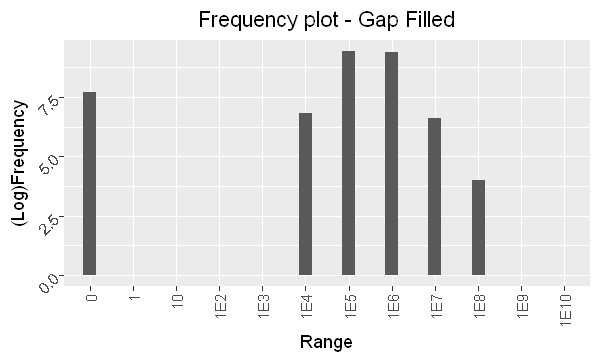

In [45]:
#creating bins from -1 to 10^10 using sequence function seq()
bins <- c(-1,0,(1 * 10^(seq(0,10,1)))) 
    
#cut function cuts the give table into its appropriate bins
scores_gapfilled <- cut(as.matrix(Blank_removal),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10')) 
    
#transform function convert the tables into a column format: easy for visualization 
FreqTable<-transform(table(scores_gapfilled)) #contains 2 columns: "scores_x1", "Freq"
FreqTable$Log_Freq <- log(FreqTable$Freq+1) #Log scaling the frequency values

colnames(FreqTable)[1] <- 'Range_Bins'
#FreqTable #Uncomment the line if you want to see the FreqTable used for the following ggplot.

## GGPLOT2
ggplot(FreqTable, aes(Range_Bins, Log_Freq))+ 
    geom_bar(stat="identity",position = "dodge", width=0.3) + 
    scale_fill_brewer(palette = "Set1") +
    ggtitle(label="Frequency plot - Gap Filled") +
    xlab("Range") + ylab("(Log)Frequency") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +   # setting the angle for the x label
    theme(axis.text.y = element_text(angle = 45, vjust = 0.5, hjust=1)) +   # setting the angle for the y label
    theme(plot.title = element_text(hjust = 0.5))

Cutoff_LOD <- round(min(Blank_removal[Blank_removal!=min(Blank_removal)]))
print(paste0("The minimum value greater than 0 in gap-filled table: ",Cutoff_LOD)) 

This minimum value will be used for imputation.

In [46]:
if(casefold(readline('Do you want to perform Imputation? - Y/N:'),upper=T) == 'Y'){
    Imputed <- Blank_removal
    Imputed[Imputed <Cutoff_LOD] <- Cutoff_LOD
    head(Imputed)
}

Do you want to perform Imputation? - Y/N: y


,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
3488_151.112_9.684,92659.64,107936.65,90535.35,84885.34,95607.41,92654.02,88818.610,91449.840,72474.910,72892.23,86713.87,123999.58
3026_153.091_8.525,226318.05,234986.17,238839.39,139233.22,145115.98,171750.98,194286.900,189326.750,215591.770,201655.44,221566.31,235400.44
685_153.139_5.391,22815.65,47993.26,40643.11,134512.40,135856.67,135126.06,8692.169,8439.676,9102.462,1267.00,1267.00,1267.00
3819_157.101_10.487,79142.02,73783.61,68608.62,99552.16,105480.26,104682.83,61277.125,64415.734,58878.953,58953.49,72545.66,59660.09
445_158.097_4.702,179699.17,189614.48,189814.78,113440.05,130959.01,192133.47,158486.980,63555.760,152527.080,185849.10,167359.47,135441.61
3501_158.154_9.708,167225.03,165643.97,179723.14,37863.93,29725.38,36029.86,130394.164,130174.766,139707.340,112410.28,128730.17,125169.77


In [47]:
dim(Imputed)

[1] 2395   12

In [48]:
write.csv(Imputed,file.path(fName,paste0('Imputed_QuantTable_filled_with_',Cutoff_LOD,'_CutOff_Used_',Cutoff,'.csv')),row.names =TRUE)

In [ ]:
#removing all the rows with only cutoff values:
#Imputed<-Imputed[rowMeans(Imputed)!= Cutoff_LOD,]  

# Step 3:Normalization
The following code performs sample-centric (column-wise) normalisation:

In [49]:
if (casefold(readline("Do you want to perform Normalization: Y/N:"),upper=T) == 'Y'){
    #Getting column-wise sums of the input-data
    sample_sum <- colSums(Imputed, na.rm= TRUE, dims = 1)
    
    #Dividing each element of a particular column with its column sum
    Normalized_data <- c()
    for (i in 1:ncol(Imputed)){
        x <- Imputed[,i] / sample_sum[i]
        Normalized_data <- cbind(Normalized_data, x)
    }
    colnames(Normalized_data) <- names(sample_sum)
    
    head(Normalized_data)
} else return(head(Imputed))
  
print(paste('No.of NA values in Normalized data:',sum(is.na(Normalized_data)== TRUE)))

Do you want to perform Normalization: Y/N: y


,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
3488_151.112_9.684,1.533098e-04,1.840176e-04,1.547153e-04,1.077076e-04,1.197759e-04,1.156262e-04,2.047205e-04,2.071079e-04,1.622811e-04,1.771504e-04,2.228138e-04,3.029750e-04
3026_153.091_8.525,3.744539e-04,4.006201e-04,4.081513e-04,1.766675e-04,1.817997e-04,2.143341e-04,4.478173e-04,4.287713e-04,4.827391e-04,4.900843e-04,5.693211e-04,5.751669e-04
685_153.139_5.391,3.774957e-05,8.182211e-05,6.945477e-05,1.706774e-04,1.701997e-04,1.686285e-04,2.003483e-05,1.911347e-05,2.038164e-05,3.079197e-06,3.255594e-06,3.095731e-06
3819_157.101_10.487,1.309442e-04,1.257912e-04,1.172449e-04,1.263178e-04,1.321445e-04,1.306374e-04,1.412394e-04,1.458833e-04,1.318379e-04,1.432750e-04,1.864082e-04,1.457708e-04
445_158.097_4.702,2.973208e-04,3.232674e-04,3.243734e-04,1.439395e-04,1.640640e-04,2.397701e-04,3.653011e-04,1.439357e-04,3.415288e-04,4.516700e-04,4.300351e-04,3.309320e-04
3501_158.154_9.708,2.766817e-04,2.824009e-04,3.071278e-04,4.804403e-05,3.723962e-05,4.496292e-05,3.005492e-04,2.948089e-04,3.128236e-04,2.731913e-04,3.307759e-04,3.058342e-04


[1] "No.of NA values in Normalized data: 0"


In [50]:
dim(Normalized_data)

[1] 2395   12

In [51]:
write.csv(Normalized_data, file.path(fName,'Normalised_Quant_table.csv'),row.names =TRUE)

All the result files would be available in the 'Result' folder within your working directory (i.e the folder path you mentioned in the beginning of the script).

## Getting output files from Google Colab:
<a id="colab_output"></a>
For Google Collab users, we can zip the result folder which contains all the output files using the next cell and download the zip file directly from the folder "/content/My_TestData" into the local system.

In [ ]:
#Only for Google Colab
utils::zip(zipfile = 'TestData_DataCleanup_Results', files = "/content/My_TestData_DataCleanup_Results/")